### Gillespie algorithm for simulating kinesin walking on microtubules in vitro
MK Iwanski <br>
Universiteit Utrecht, Kaptein Lab <br>
2020-04-07

In [113]:
# imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
import numpy as np
import math
from scipy.spatial import distance
from scipy import ndimage
#from scipy.interpolate import interp1d
from scipy.interpolate import griddata
import os 
import datetime as dt
import cv2
#from skimage import img_as_ubyte
#from sklearn.neighbors import NearestNeighbors

In [114]:
# function for debugging
def pause():
    programPause = input('Press <ENTER> to continue.')

In [115]:
# parameters
mt_length = 100 #integer
nstep = 10**4 #integer
start_num_motors = 0 #integer

length_tubulin = 8 #nm
exp_time = 100 #ms, simulation will be interpolated every exp_time ms to plot (~exposure time in experiment)

motor =  'kif1a' #'kif5b' #'other' #this will determine the velocity, landing rate, etc. Set this to anything other than 'kif1a' or 'kif5b' to enter other parameters

# options
zsave = True #save figs?
zcoop = False #simulate cooperative binding? If True, set parameters in 'update affinities of mt sites' below
zneg = False #simulate a reduction of k_on by motor binding instead of an increase? Note that zcoop must be true for this to have any effect

# observables for motor
if motor == 'kif1a':
    kin_vel = 2000 #nm/s
    kin_land_rate = 0.2 #0.2 #/min /um /pM
    kin_conc = 400 #pM in assay
    kin_run_length = 1000 #nm
elif motor == 'kif5b':
    kin_vel = 200 #nm/s
    kin_land_rate = 2 #0.2 #/min /um /nM
    kin_conc = 5 #nM in assay
    kin_run_length = 350 #nm
else:
    kin_vel = input('Enter motor velocity in nm/s: ') #nm/s
    try:
        kin_vel = float(kin_vel)
        print('motor velocity: {0} nm/s'.format(kin_vel))
    except ValueError:
        print('Please enter a valid number')
    kin_land_rate = input('Enter landing rate in /min /um /nM: ') #/min /um /nM
    try:
        kin_land_rate = float(kin_land_rate)
        print('motor landing rate: {0} /min /um /nM'.format(kin_land_rate))
    except ValueError:
        print('Please enter a valid number')
    kin_conc = input('Enter motor concentration in nM: ') #nM in assay
    try:
        kin_conc = float(kin_conc)
        print('motor concentration: {0} nM'.format(kin_conc))
    except ValueError:
        print('Please enter a valid number')
    kin_run_length = input('Enter motor run length in nm: ') #nm
    try:
        kin_run_length = float(kin_run_length)
        print('motor run length: {0} nm'.format(kin_run_length))
    except ValueError:
        print('Please enter a valid number')

#rates of reactions
k_fwd = (kin_vel/length_tubulin)/1000 #steps per msec
k_bck = 0 #steps per msec
k_on = ((kin_land_rate*kin_conc/60)/(1000/length_tubulin))/1000 #per dimer per msec 
k_off = (kin_vel/kin_run_length)/1000 #per msec

#update vectors for each reaction
nu_fwd = -1
nu_bck = -1
nu_on = 1
nu_off = -1
        
#update affinities of mt sites
fold_change_k_on = 4 #This should be > 1, papers suggest it might be around 4
if zneg == False:
    alpha_max = (fold_change_k_on)*k_on #in case of positive cooperativity, maximal k_on (at site of motor)   
elif zneg == True:
    alpha_max = (1/fold_change_k_on)*k_on #in case of negative cooperativity, minimal k_on (at site of motor)
decay_time = 10 # falls to 1/e in how much time [ms]
decay_dist = 3 # falls to 1/e in how many dimers [dimers]

In [116]:
print('k_fwd = {0:.7f} steps per msec'.format(k_fwd))
print('k_bck = {0:.7f} steps per msec'.format(k_bck))
print('k_on = {0:.7f} per dimer per msec'.format(k_on))
print('k_off = {0:.7f} per msec'.format(k_off))

k_fwd = 0.2500000 steps per msec
k_bck = 0.0000000 steps per msec
k_on = 0.0000107 per dimer per msec
k_off = 0.0020000 per msec


In [117]:
#define object track, containing motor parameters
class track:
    
    def __init__(self, trackID, **kwargs):
        self.trackID = trackID
        self.frames = []
        self.times = []
        self.positions = []
        self.isCensored = True
        
        if len(kwargs) != 0 and len(kwargs) !=3:
            frame = kwargs.get('frame', None)
            time = kwargs.get('time', None)
            position = kwargs.get('position', None)
            if frame is None:
                frame = input('Enter starting frame: ') 
                try:
                    frame = int(frame)
                except ValueError:
                    print('Please enter a valid number')
            if time is None:
                time = input('Enter starting time: ') 
                try:
                    time = float(time)
                except ValueError:
                    print('Please enter a valid number')
            if position is None:
                position = input('Enter starting position: ') 
                try:
                    position = int(position)
                except ValueError:
                    print('Please enter a valid number')

        if len(kwargs) != 0:
            self.frames.append(kwargs.get('frame'))
            self.times.append(kwargs.get('time'))
            self.positions.append(kwargs.get('position'))
            
    
    def updateTrack(self, frame, time, position):
        self.frames.append(frame)
        self.times.append(time)
        self.positions.append(position)
        
    def finishTrack(self):
        self.isCensored = False
        
    def getLocalizationsAsMatrix(self): #returns track info with frames in first column, times in msec, and positions in third
        framesMat = np.array(self.frames)
        timesMat = np.array(self.times)
        positionsMat = np.array(self.positions)
        trackInfo = np.column_stack((framesMat,timesMat,positionsMat))
        display(trackInfo)
        return trackInfo
    
    def getStartTime(self):
        startTime = self.times[0]
        return startTime
    def getStartPosition(self):
        startPosition = self.positions[0]
        return startPosition
    
    def getBoundTime(self): #returns time in s
        boundTime = (self.times[-1]-self.times[0])/1000
        return boundTime
    def getRunLength(self): #return run length in nm
        runLength = (self.positions[-1]-self.positions[0])*length_tubulin
        return runLength
    def getMeanVel(self): #returns mean vel (total run length/total time) in nm/s
        try:
            meanVel = (self.positions[-1]-self.positions[0])*length_tubulin/((self.times[-1]-self.times[0])/1000)
            #if meanVel > 2000:
            #    pause()
        except ZeroDivisionError:
            print('The track must be present for more than 1 frame to define a velocity')
            meanVel = float('nan')
        return meanVel

In [118]:
def gillespie(X, t, aff_old, k, step_num): #, nu): #update time and state (mt) vectors 
    
    #generate random numbers
    #m = np.random.randint(0,mt_length) #for lattice site
    rt = np.random.random() #for time to next reaction
    rr = np.random.random() #for type of reaction
    
    k_tot = np.sum(k)
    
    #time to next reaction
    tau = np.log(1/rt)/k_tot
    #We assume the changing affinity does not change k_tot much.
    
    #decay affinity during timestep
    if zcoop == True:
        aff = affinity_update(aff_old,X,tau) #update affinity
    else:
        aff = aff_old
     
    #update reaction matrix 
    for j in range(0,mt_length):
        if X[j] == 1: #site is occupied
            k[2,j] = 0
            k[3,j] = k_off
            if (j != mt_length-1 and X[j+1] == 0): #site in front empty
                #k[:,j] = [k_fwd, k_bck, 0, k_off]
                #nu = [nu_fwd, nu_bck, 0, nu_off]
                k[0,j] = k_fwd
            else:
                k[0,j] = 0
            if (j != 0 and X[j-1] == 0): #site behind empty
                #k[:,j] = [0, k_bck, 0, k_off]
                #nu = [0, nu_bck, 0, nu_off]
                k[1,j] = k_bck
            else:
                k[1,j] = 0
        else: #site is empty
            k[0,j] = 0
            k[1,j] = 0
            k[2,j] = aff[j]
            k[3,j] = 0
    
    k_tot = np.sum(k)
    
    m = 0 #np.random.randint(0,mt_length) #which lattice site to start with
    
    #determine which reaction
    j = 0
    test = k[0,m]/k_tot
    while test<rr: #and j<len(k[:,m])-1:  
        j += 1 
        
        if j >= len(k[:,m]): #if nothing happened at the present site, continue on to next site
            m += 1 
            if m >= mt_length: #if reached end of MT, start from beginning
                m = 0
            j = 0
           
        test += k[j,m]/k_tot

    track_to_update = next((track for track in tracks if track.positions[-1] == m), None)
    
    t += tau #update time
    X[m] += nu[j] #update state
    if j == 0:
        X[m+1] -= nu[j] #update state of +1 site for forward step
        tracks[track_to_update.trackID].updateTrack(frame=step_num,time=t,position=m+1)
    if j == 1:
        X[m-1] -= nu[j] #update state of -1 site for back step
        tracks[track_to_update.trackID].updateTrack(frame=step_num,time=t,position=m-1)
    if j == 2:
        if len(tracks) == 0:
            motor_number = 0
        else:
            motor_number = tracks[-1].trackID+1
        tracks.append(track(motor_number,frame=step_num,time=t,position=m))
    if j == 3:
        tracks[track_to_update.trackID].finishTrack()
  
    return X, t, aff, k

In [119]:
def alt_gillespie(X, t, aff_old, k, step_num): #, nu): #update time and state (mt) vectors 
    
    #generate random numbers
    #m = np.random.randint(0,mt_length) #for lattice site
    rt = np.random.random() #for time to next reaction
    rr = np.random.random() #for type of reaction
    
    k_tot = np.sum(k)
    
    #time to next reaction
    tau = np.log(1/rt)/k_tot
    #We assume the changing affinity does not change k_tot much.
    
    #decay affinity during timestep
    if zcoop == True:
        aff = affinity_update(aff_old,X,tau) #update affinity
    else:
        aff = aff_old
     
    #update reaction matrix 
    for j in range(0,mt_length):
        if X[j] == 1: #site is occupied
            k[2,j] = 0
            k[3,j] = k_off
            if (j != mt_length-1 and X[j+1] == 0): #site in front empty
                #k[:,j] = [k_fwd, k_bck, 0, k_off]
                #nu = [nu_fwd, nu_bck, 0, nu_off]
                k[0,j] = k_fwd
            else:
                k[0,j] = 0
            if (j != 0 and X[j-1] == 0): #site behind empty
                #k[:,j] = [0, k_bck, 0, k_off]
                #nu = [0, nu_bck, 0, nu_off]
                k[1,j] = k_bck
            else:
                k[1,j] = 0
        else: #site is empty
            k[0,j] = 0
            k[1,j] = 0
            k[2,j] = aff[j]
            k[3,j] = 0
    
    k_tot = np.sum(k)
    
    #m = 0 #np.random.randint(0,mt_length) #which lattice site to start with
    
    #determine which reaction of motor binds, motor unbinds, motor steps foward, motor steps backward
    #which motor/lattice site will be chosen subsequently
    
    tot_k_fwd = np.sum(k[0,:])
    tot_k_bck = np.sum(k[1,:])
    tot_k_on = np.sum(k[2,:])
    tot_k_off = np.sum(k[3,:])
    tot_k_all = [tot_k_fwd, tot_k_bck, tot_k_on, tot_k_off]
    
    j = 0
    test = tot_k_all[0]/k_tot
    while test<rr: #and j<len(k[:,m])-1:  
        j += 1 
        
        if j >= len(tot_k_all[:]): #if nothing happened at the present site, continue on to next site
            m += 1 
            if m >= mt_length: #if reached end of MT, start from beginning
                m = 0
            j = 0
           
        test += tot_k_all[j]/k_tot

    track_to_update = next((track for track in tracks if track.positions[-1] == m), None)
    
    t += tau #update time
    
    if j == 0:
        #choose random m where X==1 and +1 site is 0
        X[m] += nu[j] #update state
        X[m+1] -= nu[j] #update state of +1 site for forward step
        tracks[track_to_update.trackID].updateTrack(frame=step_num,time=t,position=m+1)
    if j == 1:
        #choose random m where X==1 and -1 site is 0
        X[m] += nu[j] #update state
        X[m-1] -= nu[j] #update state of -1 site for back step
        tracks[track_to_update.trackID].updateTrack(frame=step_num,time=t,position=m-1)
    if j == 2:
        if len(tracks) == 0:
            motor_number = 0
        else:
            motor_number = tracks[-1].trackID+1
        #choose random m where X==0, but weighted by affinity of individual lattice sites?
        X[m] += nu[j] #update state
        tracks.append(track(motor_number,frame=step_num,time=t,position=m))
    if j == 3:
        #choose random m where X==1?
        X[m] += nu[j] #update state
        tracks[track_to_update.trackID].finishTrack()
  
    return X, t, aff, k

In [120]:
def find_closest_motor(lattice_site, motors):
    assert isinstance(lattice_site,int)
    
    motors = np.asarray(motors)
    idx = (np.abs(motors - lattice_site)).argmin()
    return motors[0,idx] 

In [121]:
def affinity_update(aff, X, t_step): #update affinity based on motor positions
    
    if zneg == False:
        decay_aff = k_on + (aff-k_on)*np.exp(-t_step/decay_time) #affinities decay with time (back to baseline) 
        #print('aff = {0}, decay_aff = {1}'.format(aff, decay_aff))
        #pause()
    elif zneg == True:
        decay_aff=k_on-(k_on-aff)*np.exp(-t_step/decay_time) #affinities increase with time (back to baseline)
    
    motor_aff = np.zeros(aff.shape,dtype='float')
    motor_aff[:] = k_on
    
    motors = np.asarray(np.where(X==1), dtype=np.int)
    motors.flatten()

    if motors.size != 0:
        motor_aff[X==1] = alpha_max #affinity at motor positions increase to max value
        for j in range(0,mt_length):
            #for each lattice site, find closest motor
            closest_motor = find_closest_motor(j,motors)
            distance_from_site = int(np.abs(closest_motor-j))
            if zneg == False:
                motor_aff[j] = alpha_max*np.exp(-distance_from_site/decay_dist) #update affinity based on closest motor
            elif zneg == True:
                motor_aff[j] = k_on-(k_on-alpha_max)*np.exp(-distance_from_site/decay_dist) #update affinity based on closest motor

            
    new_aff = np.zeros(aff.shape,dtype='float') 
    if zneg == False:
        for j in range(0,mt_length):
            #new_aff[j] = decay_aff[j]
            #new_aff[X==1] = alpha_max
            if motor_aff[j] > decay_aff[j]:
                new_aff[j] = motor_aff[j]
            else:
                new_aff[j] = decay_aff[j]
    elif zneg == True:
        for j in range(0,mt_length):
            if motor_aff[j] < decay_aff[j]:
                new_aff[j] = motor_aff[j]
            else:
                new_aff[j] = decay_aff[j]

    if zneg == False:
        new_aff[new_aff<k_on] = k_on #set back to baseline if below
        new_aff[new_aff>alpha_max] = alpha_max #set back to max if above
    elif zneg == True:
        new_aff[new_aff<alpha_max] = alpha_max #set back to minimum if below
        new_aff[new_aff>k_on] = k_on #set back to baseline level if above
    
    return new_aff

In [122]:
#initialize
mt = np.zeros((nstep,mt_length), dtype=np.int)
affinity = np.zeros((nstep,mt_length))
affinity[:] = k_on
t = np.zeros(nstep)
tracks = []

#place motor(s) on MT to begin
if start_num_motors != 0:
    for i in range(0,start_num_motors):
        m = np.random.randint(0,mt_length)
        mt[0,m] = 1
        tracks.append(track(i,frame=0,time=0,position=m))
        
k = np.zeros((4,mt_length),dtype=np.float)
for j in range(0,mt_length):
    if mt[0,j] == 1: #site is occupied
        k[2,j] = 0
        k[3,j] = k_off
        if (j != mt_length-1 and mt[0,j+1] == 0): #site in front empty
            #k[:,j] = [k_fwd, k_bck, 0, k_off]
            #nu = [nu_fwd, nu_bck, 0, nu_off]
            k[0,j] = k_fwd
        else:
            k[0,j] = 0
        if (j != 0 and mt[0,j-1] == 0): #site behind empty
            #k[:,j] = [0, k_bck, 0, k_off]
            #nu = [0, nu_bck, 0, nu_off]
            k[1,j] = k_bck
        else:
            k[1,j] = 0
    else: #site is empty
        k[0,j] = 0
        k[1,j] = 0
        k[2,j] = k_on
        k[3,j] = 0
nu = [nu_fwd, nu_bck, nu_on, nu_off]

In [123]:
#run Gillespie
for i in range(0,nstep-1):
    
    #k = np.zeros((4,mt_length),dtype=np.float)
    
#    #update reaction matrix 
#    for j in range(0,mt_length):
#        if mt[i,j] == 1: #site is occupied
#            k[2,j] = 0
#            k[3,j] = k_off
#            if (j != mt_length-1 and mt[i,j+1] == 0): #site in front empty
#                #k[:,j] = [k_fwd, k_bck, 0, k_off]
#                #nu = [nu_fwd, nu_bck, 0, nu_off]
#                k[0,j] = k_fwd
#            else:
#                k[0,j] = 0
#            if (j != 0 and mt[i,j-1] == 0): #site behind empty
#                #k[:,j] = [0, k_bck, 0, k_off]
#                #nu = [0, nu_bck, 0, nu_off]
#                k[1,j] = k_bck
#            else:
#                k[1,j] = 0
#        else: #site is empty
#            k[0,j] = 0
#            k[1,j] = 0
#            k[2,j] = affinity[i,j]
#            k[3,j] = 0

    mt[i+1,:],t[i+1],affinity[i+1],k = gillespie(mt[i,:],t[i],affinity[i,:],k,i) #,nu)
    
#    if zcoop == True:
#        affinity[i+1,:] = affinity_update(affinity[i,:],mt[i+1,:],(t[i+1]-t[i])) #future update of affinity

#pause() 

print('The average time step was {0:.5f} sec'. format(np.mean(np.diff(t))/1000))
print('The total time was {0:.5f} min or {1:.5f} msec'. format((t[-1]/60)/1000, t[-1]))

The average time step was 0.02346 sec
The total time was 3.91021 min or 234612.56590 msec


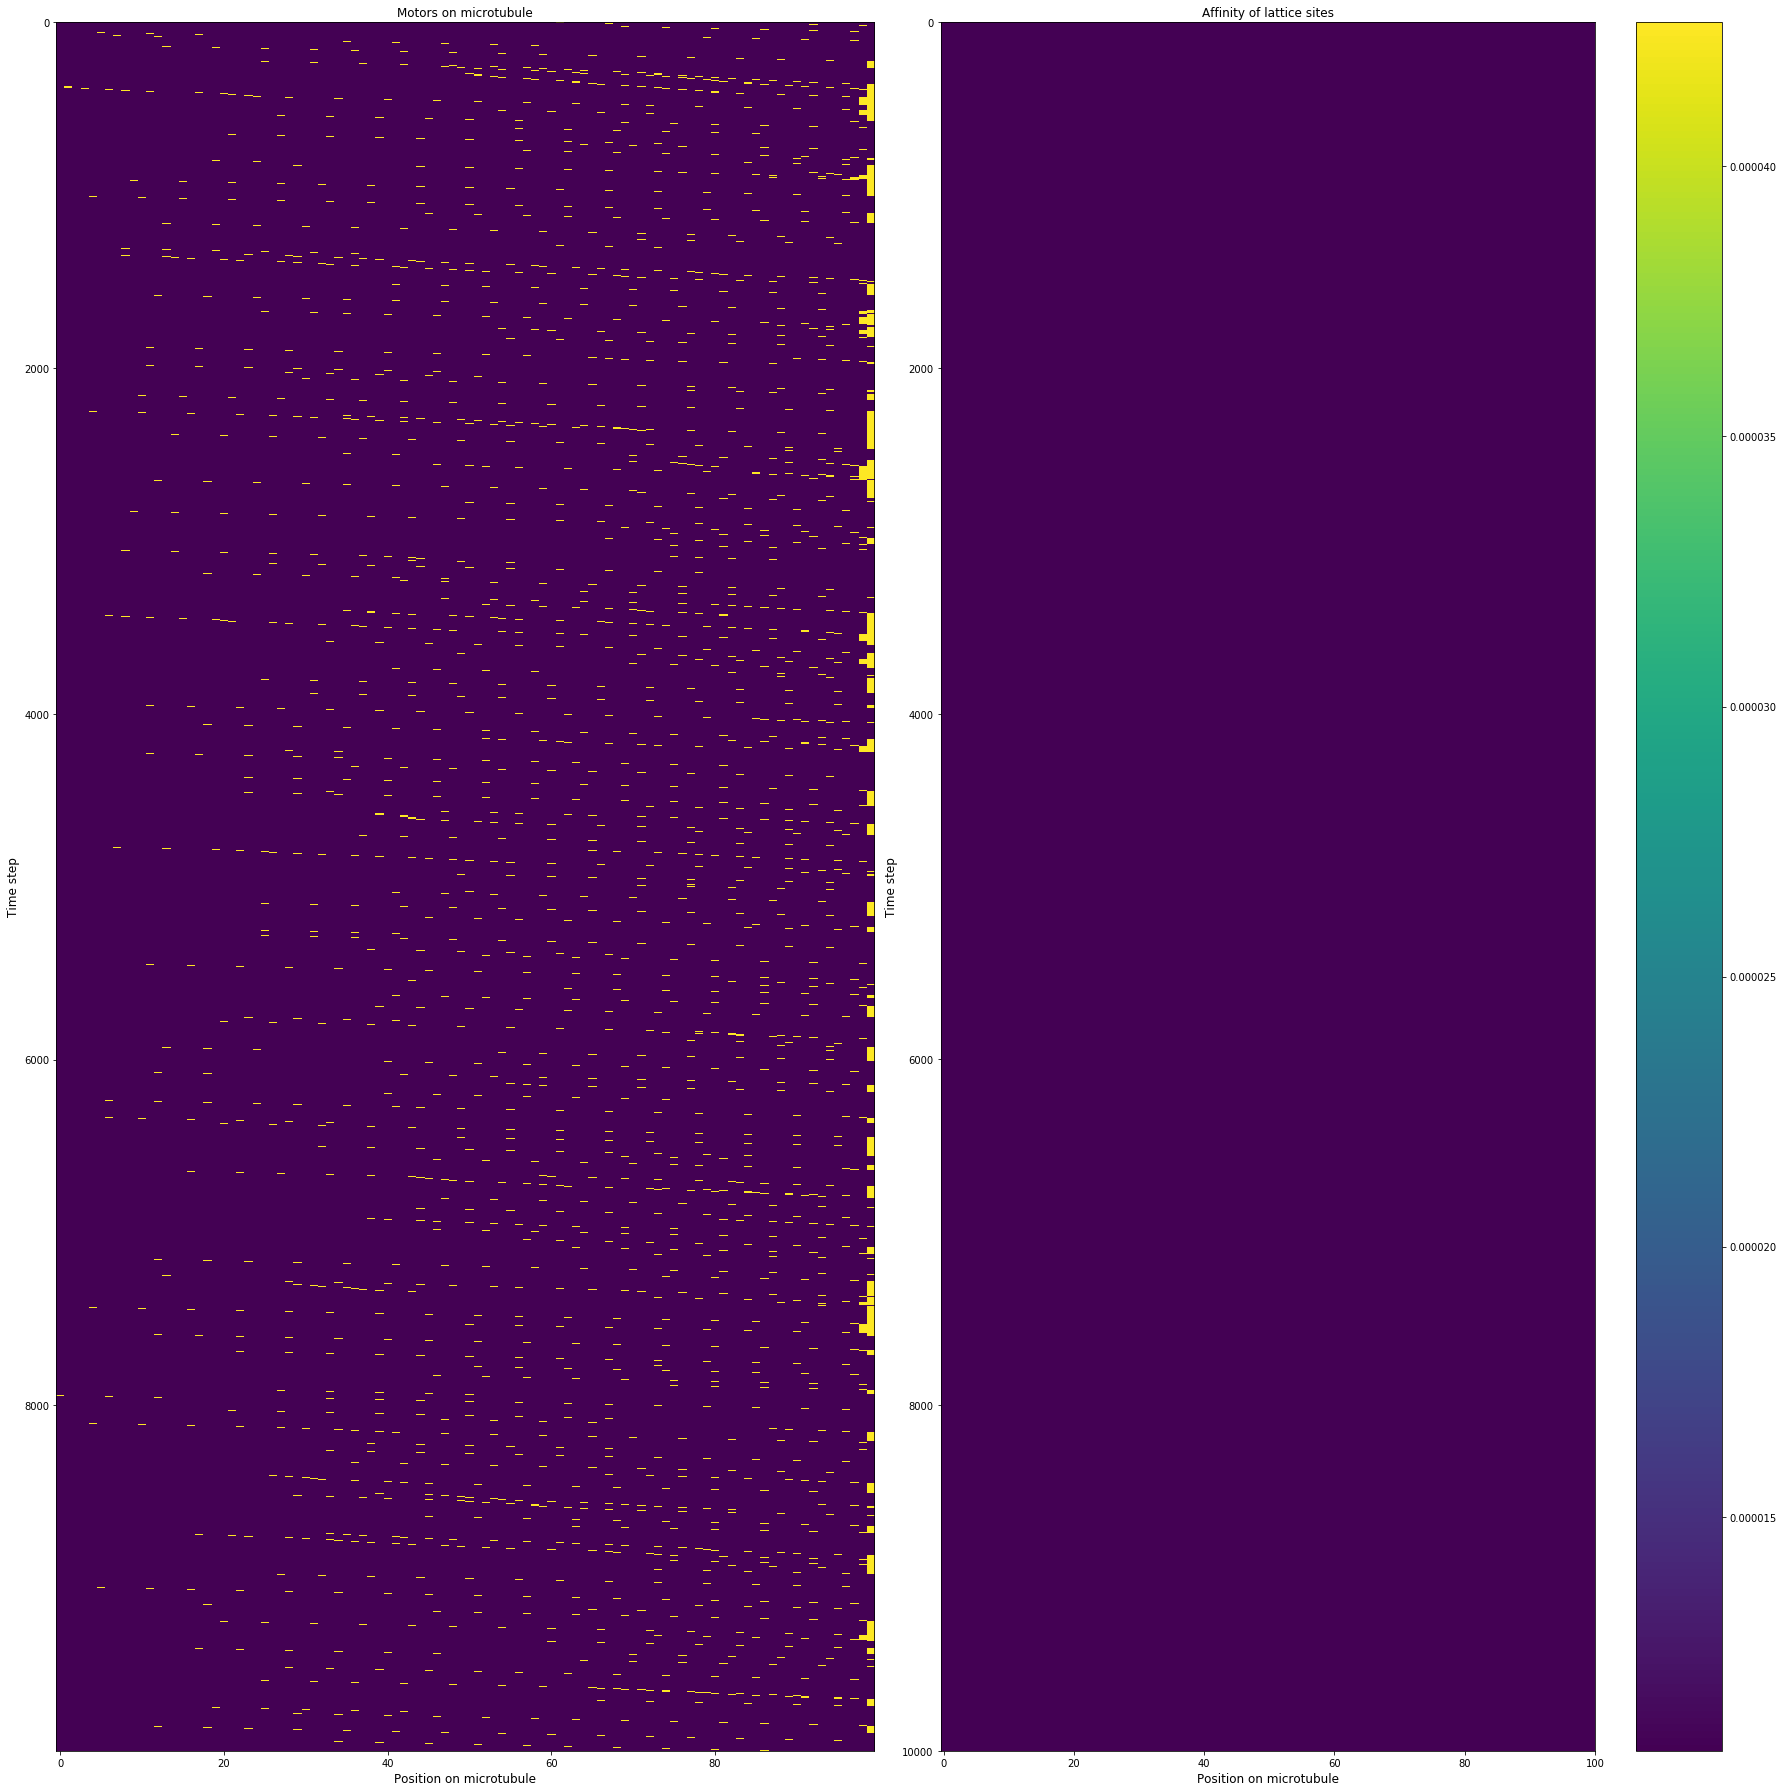

In [124]:
# plot results
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(25, 25)) #25x30 for 100 dimers, 10^3 steps; 25x3 for 1000 dimers, 10^3 steps; 25x100 for 1000 dimers, 10^5 steps
if zneg == False:
    color_lim = (k_on,alpha_max)
elif zneg == True:
    color_lim = (alpha_max,k_on)

ax[0].imshow(mt, cmap='viridis', aspect='auto', interpolation='nearest',clim=(color_lim[0],color_lim[1]))
ax[0].set_title("Motors on microtubule", fontsize=12)
ax[0].set_ylabel("Time step", fontsize=12)
ax[0].set_xlabel("Position on microtubule", fontsize=12)
#pcm = ax[1].pcolormesh(mt,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')

ax[1].imshow(affinity, cmap='viridis', aspect='auto', interpolation='nearest',clim=(color_lim[0],color_lim[1]))
ax[1].set_title("Affinity of lattice sites", fontsize=12)
ax[1].set_ylabel("Time step", fontsize=12)
ax[1].set_xlabel("Position on microtubule", fontsize=12)
pcm = ax[1].pcolormesh(affinity,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')
fig.colorbar(pcm, ax=ax[1])

plt.tight_layout()

# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name,dpi=130)

plt.show()

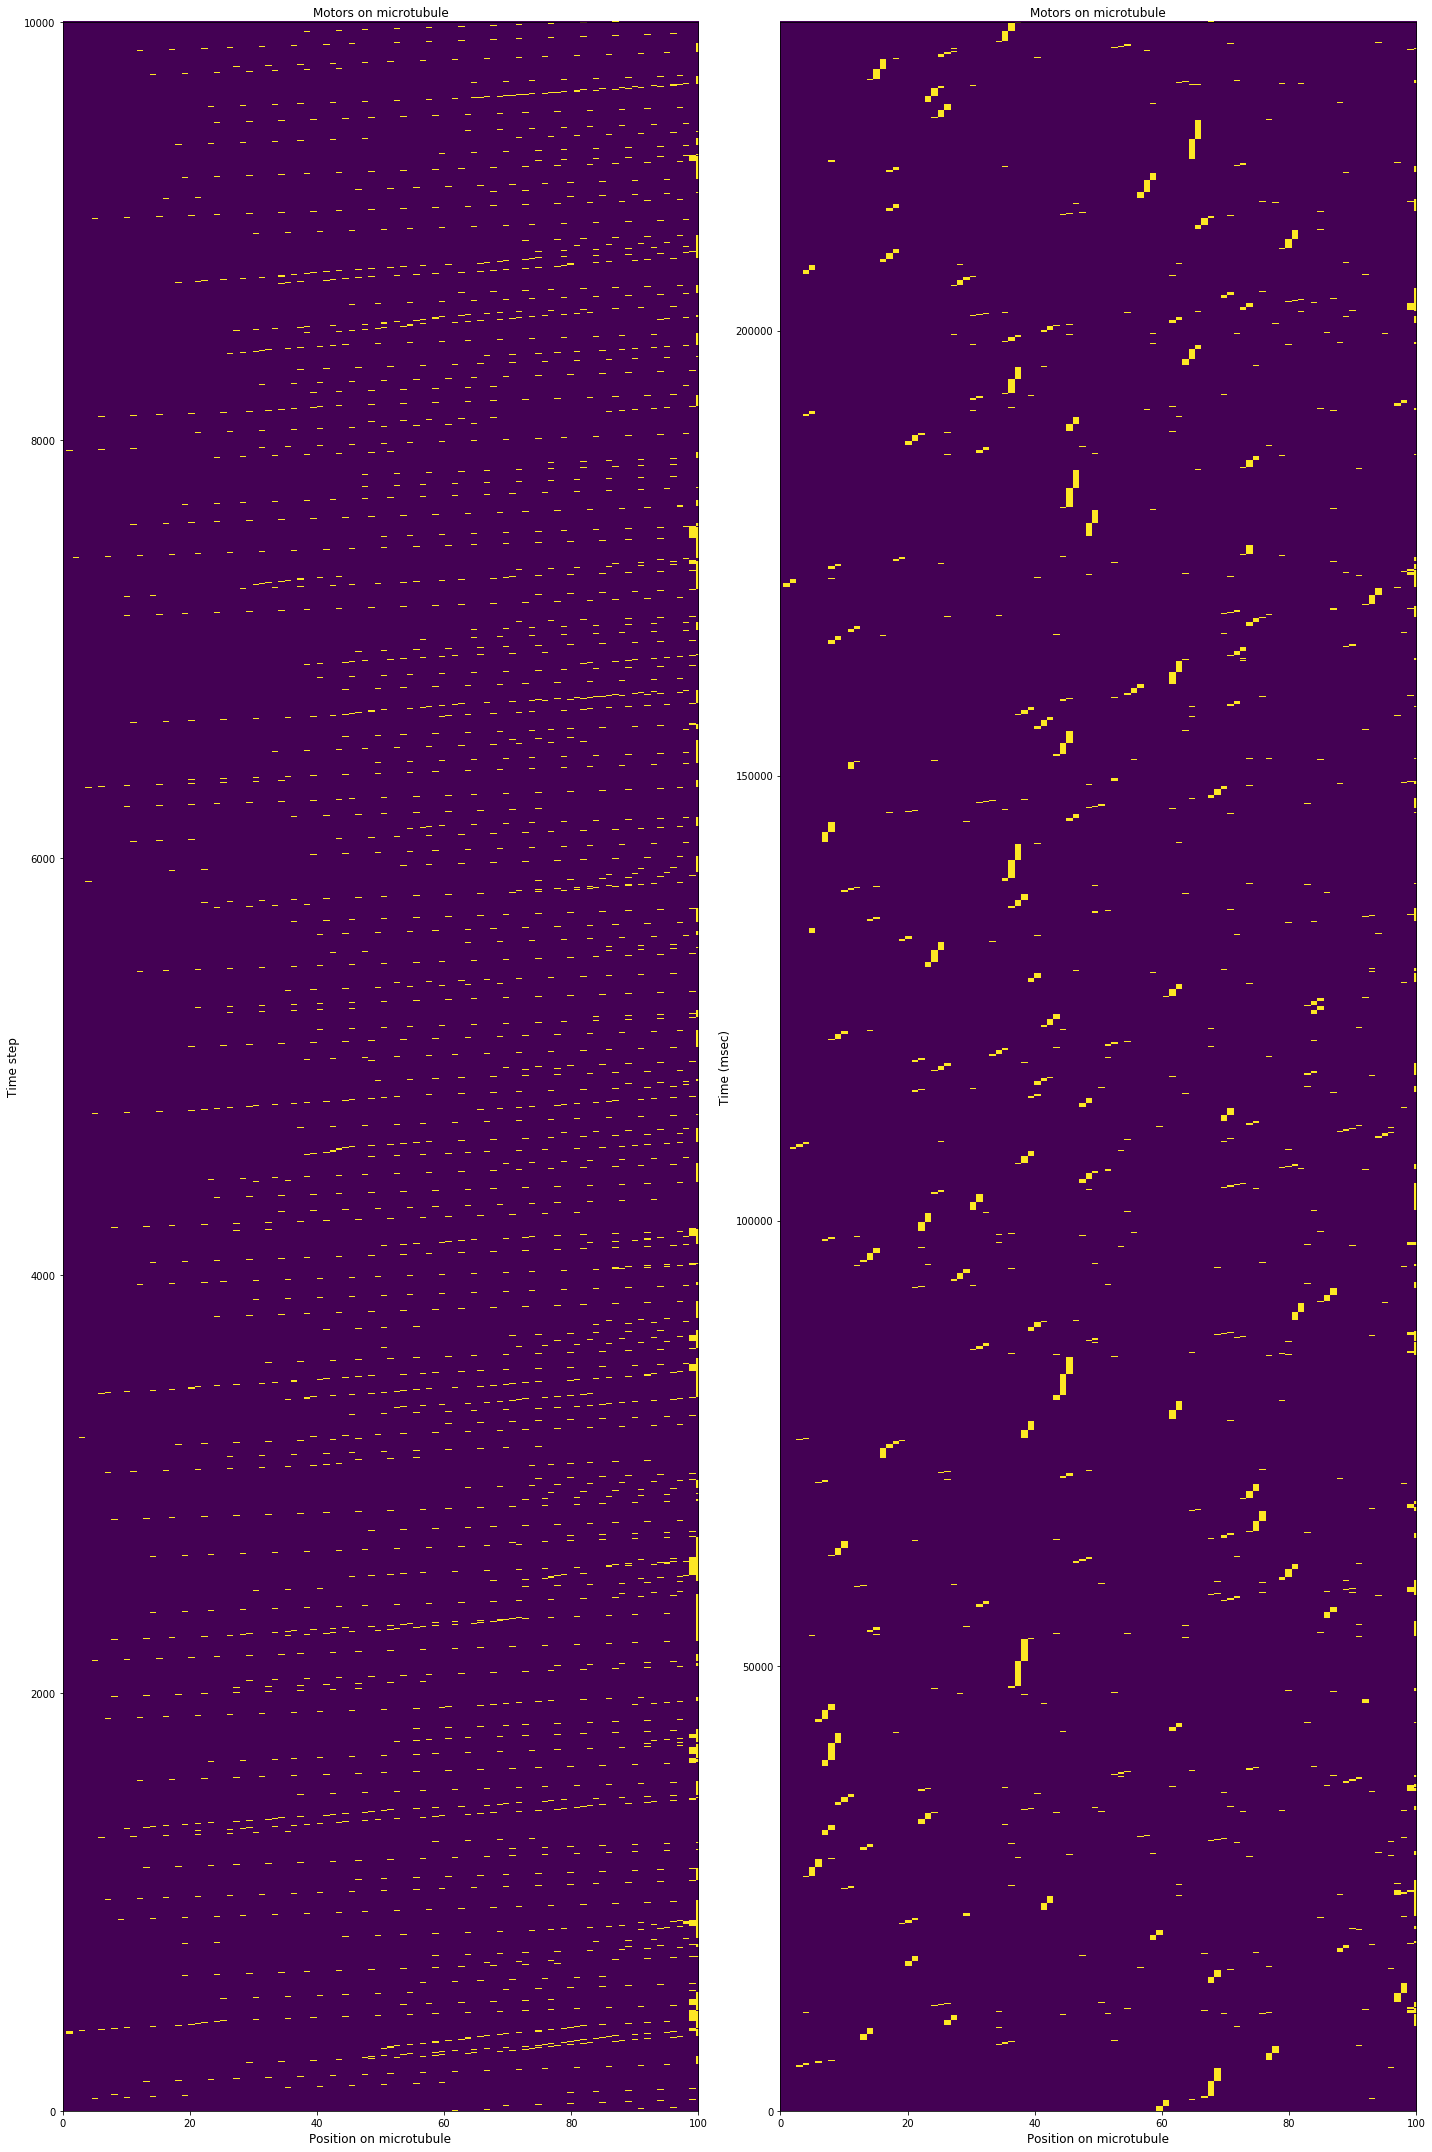

In [125]:
#plot kymographs with "real" time between frames
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 30))
if zneg == False:
    color_lim = (k_on,alpha_max)
elif zneg == True:
    color_lim = (alpha_max,k_on)

x = np.linspace(0, mt_length, mt_length)
y = np.linspace(0, nstep, nstep)
y2 = t
z = mt

im = NonUniformImage(ax[0], interpolation='nearest', extent=(0, mt_length, 0, nstep), origin = 'upper',cmap='viridis',clim=(color_lim[0],color_lim[1]))
im.set_data(x, y, z)
ax[0].images.append(im)
ax[0].set_xlim(0, mt_length)
ax[0].set_ylim(0, nstep)
ax[0].set_title("Motors on microtubule", fontsize=12)
ax[0].set_ylabel("Time step", fontsize=12)
ax[0].set_xlabel("Position on microtubule", fontsize=12)

im = NonUniformImage(ax[1], interpolation='nearest', extent=(0, mt_length, 0, t[-1]), origin = 'upper',cmap='viridis',clim=(color_lim[0],color_lim[1]))
im.set_data(x, y2, z)
ax[1].images.append(im)
ax[1].set_xlim(0, mt_length)
ax[1].set_ylim(0, t[-1])
ax[1].set_title("Motors on microtubule", fontsize=12)
ax[1].set_ylabel("Time (msec)", fontsize=12)
ax[1].set_xlabel("Position on microtubule", fontsize=12)

plt.tight_layout()

# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_kymograph_vartimepx{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name,dpi=130)

plt.show()

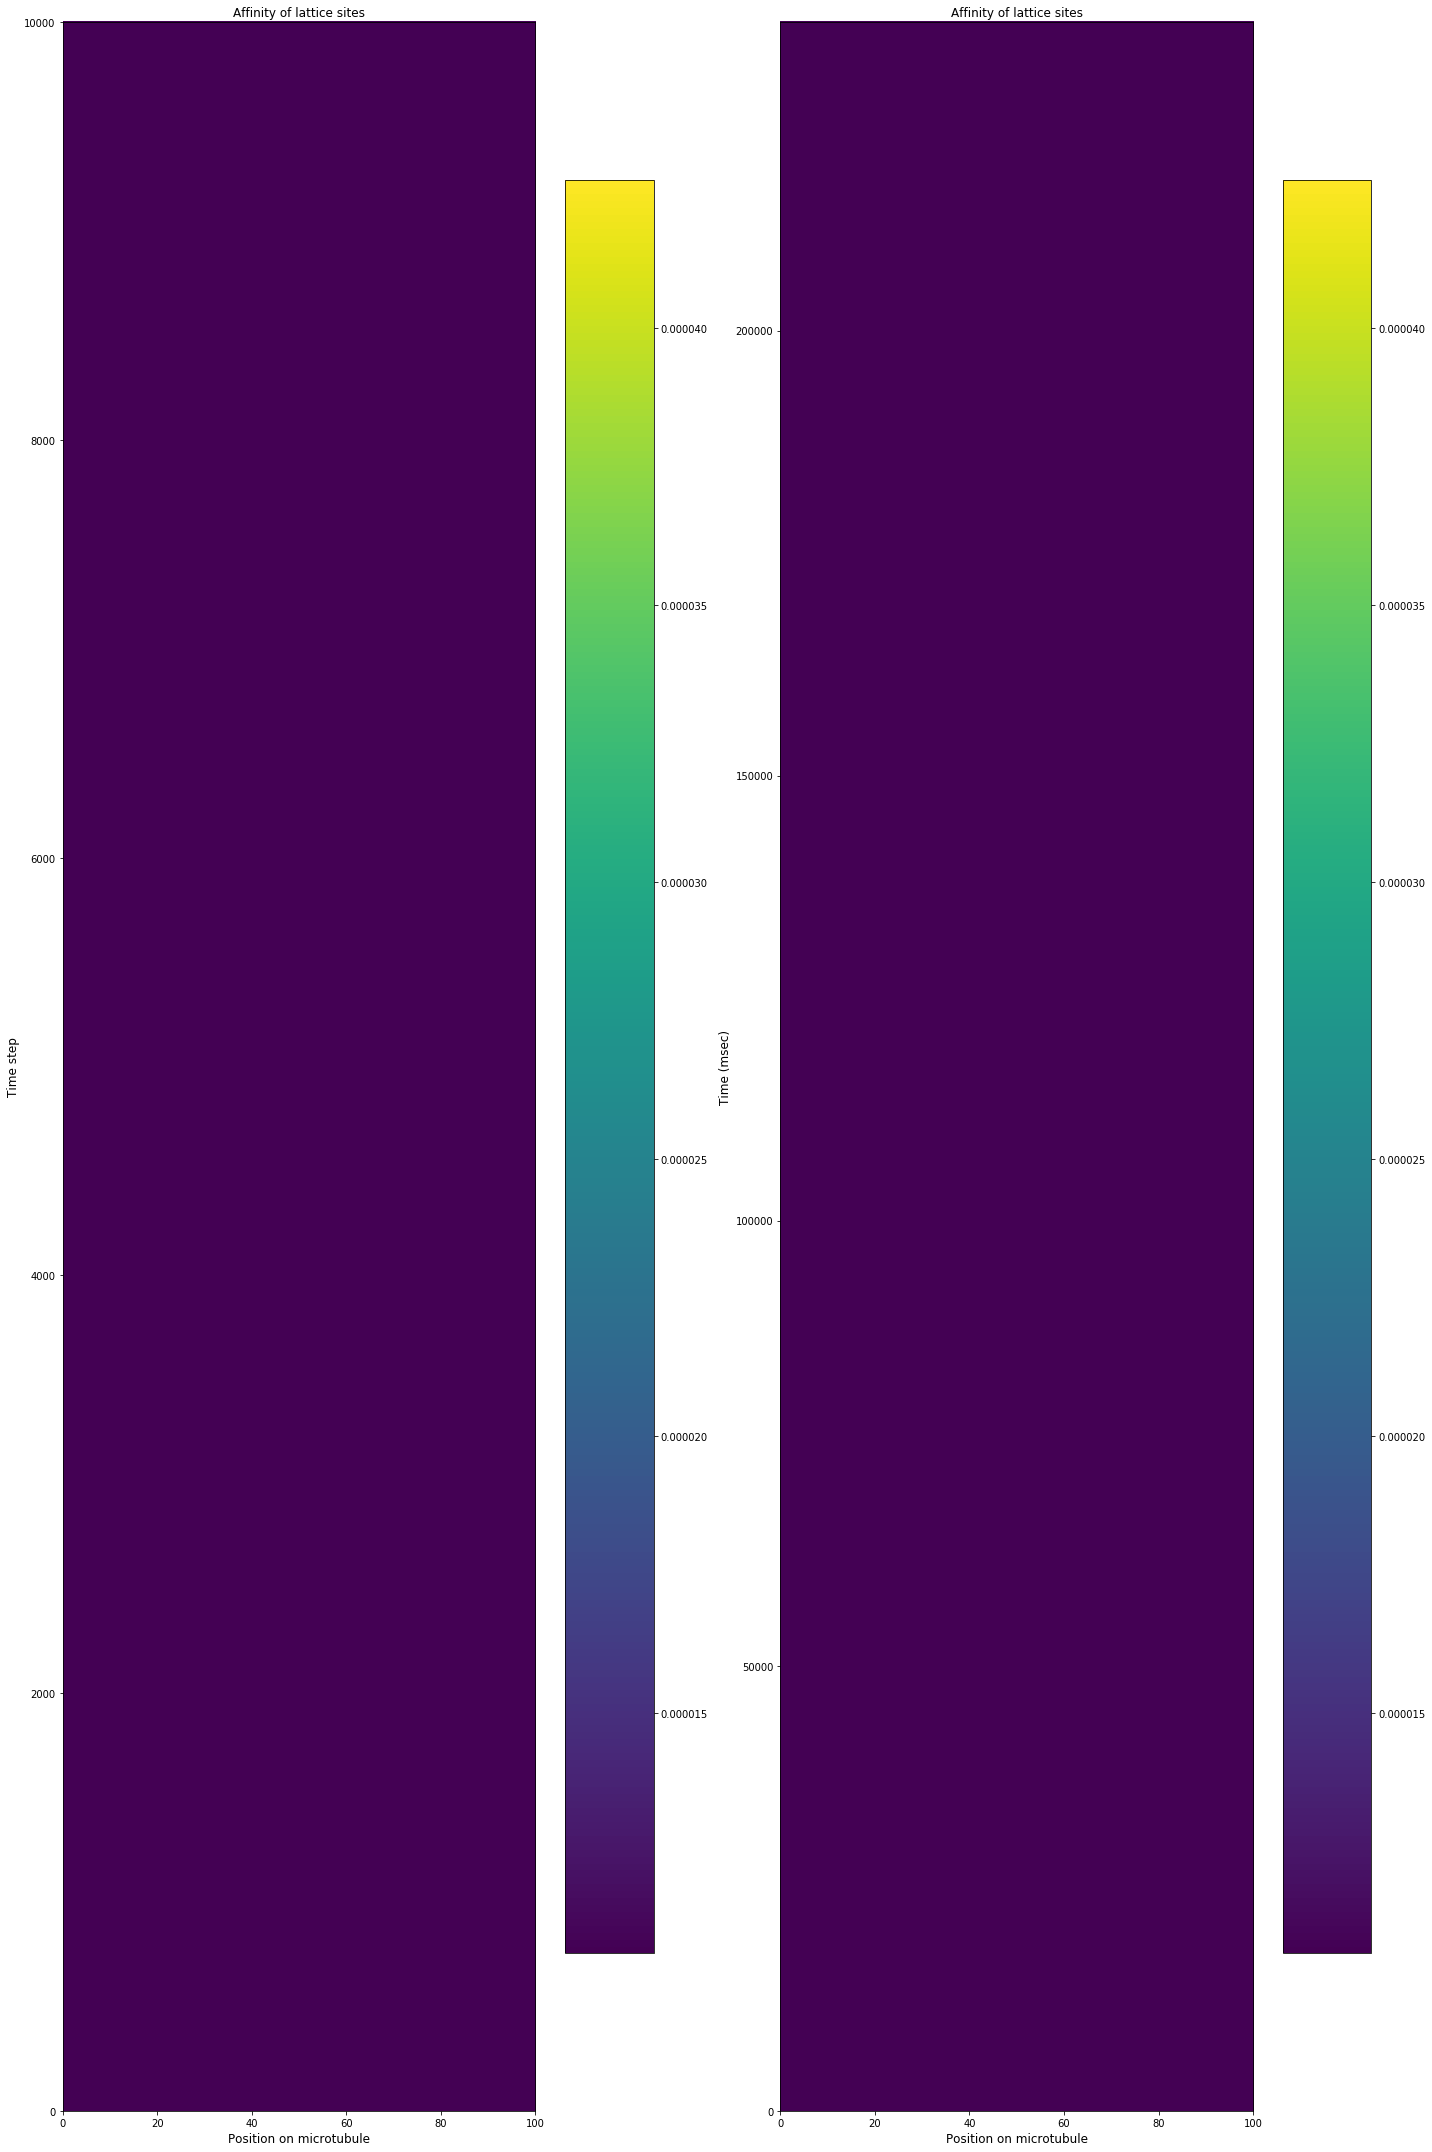

In [126]:
#plot affinity with "real" time between frames
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 30))
if zneg == False:
    color_lim = (k_on,alpha_max)
elif zneg == True:
    color_lim = (alpha_max,k_on)

x = np.linspace(0, mt_length, mt_length)
y = np.linspace(0, nstep, nstep)
y2 = t
z = affinity

im = NonUniformImage(ax[0], interpolation='nearest', extent=(0, mt_length, 0, nstep), origin = 'upper',cmap='viridis',clim=(color_lim[0],color_lim[1]))
im.set_data(x, y, z)
ax[0].images.append(im)
ax[0].set_xlim(0, mt_length)
ax[0].set_ylim(0, nstep)
ax[0].set_title("Affinity of lattice sites", fontsize=12)
ax[0].set_ylabel("Time step", fontsize=12)
ax[0].set_xlabel("Position on microtubule", fontsize=12)
pcm = ax[0].pcolormesh(affinity,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')
fig.colorbar(pcm, ax=ax[0])

im = NonUniformImage(ax[1], interpolation='nearest', extent=(0, mt_length, 0, t[-1]), origin = 'upper',cmap='viridis',clim=(color_lim[0],color_lim[1]))
im.set_data(x, y2, z)
ax[1].images.append(im)
ax[1].set_xlim(0, mt_length)
ax[1].set_ylim(0, t[-1])
ax[1].set_title("Affinity of lattice sites", fontsize=12)
ax[1].set_ylabel("Time (msec)", fontsize=12)
ax[1].set_xlabel("Position on microtubule", fontsize=12)
pcm = ax[1].pcolormesh(affinity,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')
fig.colorbar(pcm, ax=ax[1])

plt.tight_layout()

# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_affinity_vartimepx{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name,dpi=130)
    
plt.show()

In [127]:
# interpolate for even time steps
x = np.linspace(0, mt_length, mt_length)
y = np.linspace(0, t[-1], math.floor(t[-1]/exp_time)) #np.linspace(0, nstep, nstep)
y2 = t
z = mt
#grid = np.ndarray((mt_length, math.floor(t[-1]/exp_time)))
grid = np.mgrid[0:mt_length:int(mt_length)*j,0:t[-1]:int(math.floor(t[-1]/exp_time))*j]
interp_mt = griddata(t, mt, y, method='nearest')
interp_affinity = griddata(t, affinity, y, method='nearest')

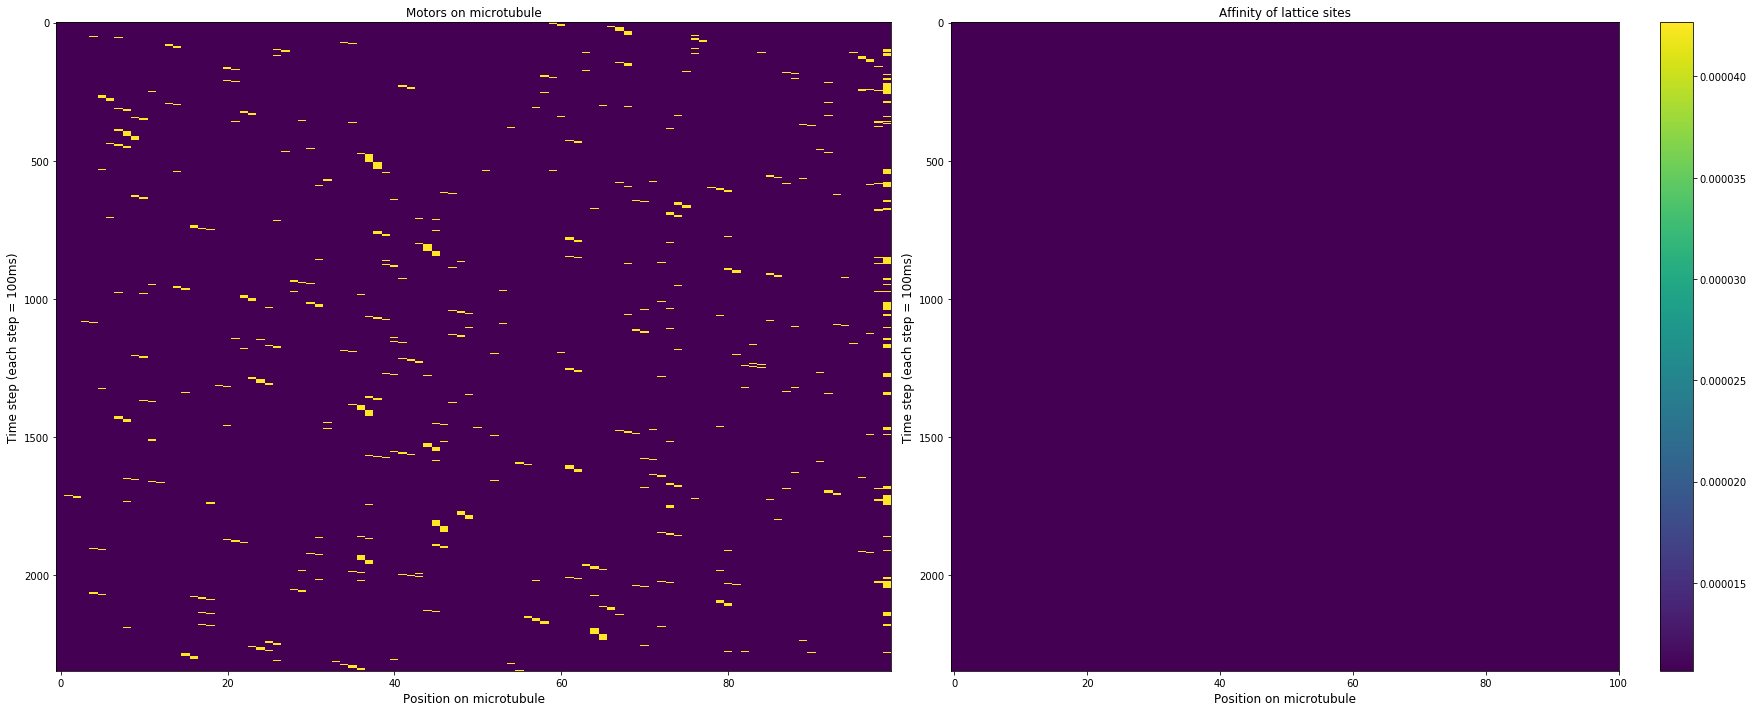

In [128]:
# plot interpolated results
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(25, 10)) 
if zneg == False:
    color_lim = (k_on,alpha_max)
elif zneg == True:
    color_lim = (alpha_max,k_on)

ax[0].imshow(interp_mt, cmap='viridis', aspect='auto', interpolation='nearest',clim=(color_lim[0],color_lim[1]))
ax[0].set_title("Motors on microtubule", fontsize=12)
ax[0].set_ylabel("Time step (each step = 100ms)", fontsize=12)
ax[0].set_xlabel("Position on microtubule", fontsize=12)
#pcm = ax[1].pcolormesh(mt,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')

ax[1].imshow(interp_affinity, cmap='viridis', aspect='auto', interpolation='nearest',clim=(color_lim[0],color_lim[1]))
ax[1].set_title("Affinity of lattice sites", fontsize=12)
ax[1].set_ylabel("Time step (each step = 100ms)", fontsize=12)
ax[1].set_xlabel("Position on microtubule", fontsize=12)
pcm = ax[1].pcolormesh(interp_affinity,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')
fig.colorbar(pcm, ax=ax[1])

plt.tight_layout()

# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'InterpolatedSimulation_{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name,dpi=130)

plt.show()

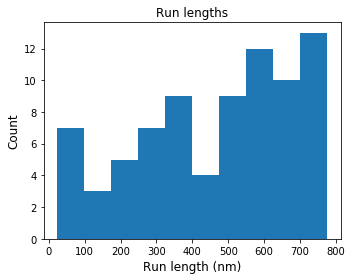

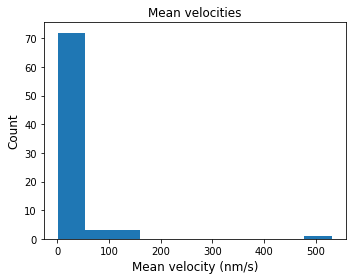

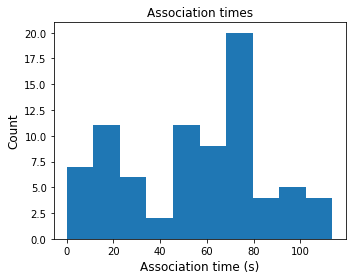

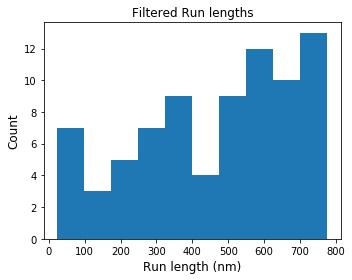

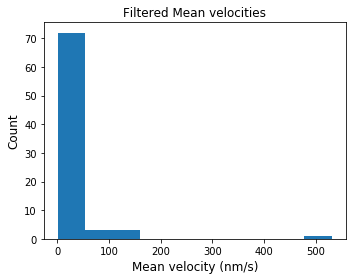

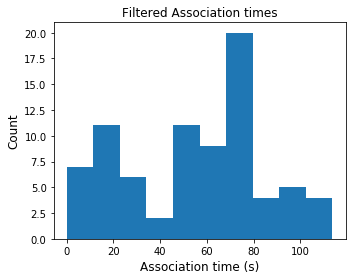

In [129]:
#calculate cumulative track statistics
all_run_lengths = []
all_mean_vels = []
all_bound_times = []

filt_run_lengths = []
filt_mean_vels = []
filt_bound_times = []

for i in range(len(tracks)):
    if tracks[i].isCensored == False:
        all_run_lengths.append(tracks[i].getRunLength())
        all_mean_vels.append(tracks[i].getMeanVel())
        all_bound_times.append(tracks[i].getBoundTime())
        if len(tracks[i].frames) >= 4:
            filt_run_lengths.append(tracks[i].getRunLength())
            filt_mean_vels.append(tracks[i].getMeanVel())
            filt_bound_times.append(tracks[i].getBoundTime())

#plot run length histogram
fig, ax = plt.subplots(1,1, figsize=(5, 4))
ax.hist(all_run_lengths, density=False)
ax.set_title("Run lengths", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Run length (nm)", fontsize=12)
plt.tight_layout()
# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_RunLengthHist{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name)
plt.show()

#plot velocity histogram
fig, ax = plt.subplots(1,1, figsize=(5, 4))
ax.hist(all_mean_vels, density=False)
ax.set_title("Mean velocities", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Mean velocity (nm/s)", fontsize=12)
plt.tight_layout()
# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_MeanVelHist{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name)
plt.show()

#plot bound time histogram
fig, ax = plt.subplots(1,1, figsize=(5, 4))
ax.hist(all_bound_times, density=False)
ax.set_title("Association times", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Association time (s)", fontsize=12)
plt.tight_layout()
# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_BoundTimeHist{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name)
plt.show()

#plot filtered run length histogram
fig, ax = plt.subplots(1,1, figsize=(5, 4))
ax.hist(filt_run_lengths, density=False)
ax.set_title("Filtered Run lengths", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Run length (nm)", fontsize=12)
plt.tight_layout()
# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_FiltRunLengthHist{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name)
plt.show()

#plot velocity histogram
fig, ax = plt.subplots(1,1, figsize=(5, 4))
ax.hist(filt_mean_vels, density=False)
ax.set_title("Filtered Mean velocities", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Mean velocity (nm/s)", fontsize=12)
plt.tight_layout()
# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_FiltMeanVelHist{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name)
plt.show()

#plot bound time histogram
fig, ax = plt.subplots(1,1, figsize=(5, 4))
ax.hist(filt_bound_times, density=False)
ax.set_title("Filtered Association times", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Association time (s)", fontsize=12)
plt.tight_layout()
# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_FiltBoundTimeHist{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name)
plt.show()

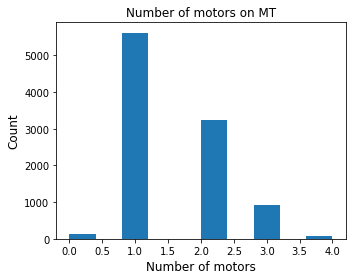

The expected average number of motors bound in the case of no cooperativity is 0.16621930941148105


In [130]:
#find average number of motors on MT at each time step
num_motors_on_mt = []
for i in range(nstep):
    num_motors_on_mt.append(np.sum(mt[i,:]))

#plot number of motors on MT
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.hist(num_motors_on_mt, density=False)
ax.set_title("Number of motors on MT", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Number of motors", fontsize=12)

plt.tight_layout()

# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_NumMotorsOnMTHist{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name)

plt.show()

#theoretical result for non-cooperative case
dimlessRL = (k_off*1000)*mt_length*length_tubulin/kin_vel #dimensionless MT length
num_bound = (k_on*1000)*(kin_vel/length_tubulin)/(k_off*1000)**2 #number of motors that bind per unit time per unit length

avg_num_motors = num_bound*dimlessRL*(1-(1/dimlessRL)*(1-np.exp(-dimlessRL)))
print('The expected average number of motors bound in the case of no cooperativity is {0}'.format(avg_num_motors))

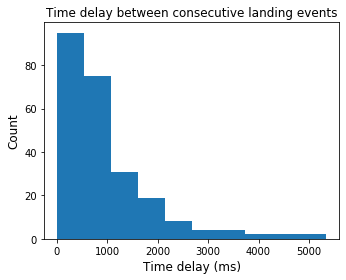

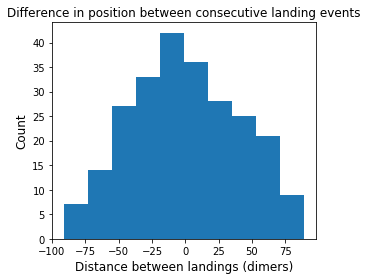

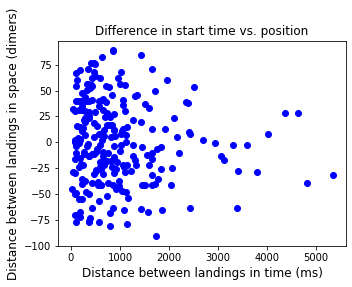

In [135]:
# analyze landing time between events
track_start_times = []
track_start_positions = []
for i in range(len(tracks)):
    if tracks[i].getStartTime() != 0 or tracks[i].getStartTime() != 0.:
        track_start_times.append(tracks[i].getStartTime())
        track_start_positions.append(tracks[i].getStartPosition())

sorted_start_positions = [tsp for _,tsp in sorted(zip(track_start_times,track_start_positions))] #sort start positions based on time

track_start_times.sort()
delta_start_time = np.diff(track_start_times)
delta_start_position = np.diff(sorted_start_positions)
#delta_start_position = np.diff(track_start_positions)

#plot difference between landing times
fig, ax = plt.subplots(1,1, figsize=(5, 4))
ax.hist(delta_start_time, density=False)
ax.set_title("Time delay between consecutive landing events", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Time delay (ms)", fontsize=12)
plt.tight_layout()
# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_DelaybwLandingsTimeHist{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name)
plt.show()

#plot difference between landing positions
fig, ax = plt.subplots(1,1, figsize=(5, 4))
ax.hist(delta_start_position, density=False)
ax.set_title("Difference in position between consecutive landing events", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Distance between landings (dimers)", fontsize=12)
plt.tight_layout()
# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_DelaybwLandingsSpaceHist{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name)
plt.show()

#plot difference between landing positions
fig, ax = plt.subplots(1,1, figsize=(5, 4))
ax.plot(delta_start_time, delta_start_position,'bo')
ax.set_title("Difference in start time vs. position", fontsize=12)
ax.set_ylabel("Distance between landings in space (dimers)", fontsize=12)
ax.set_xlabel("Distance between landings in time (ms)", fontsize=12)
plt.tight_layout()
# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_DelaybwLandingsSpacevsTime{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name)
plt.show()

In [132]:
# only run past this point to save a movie of the simulation

In [110]:
#reformat to create an image from each time point
mt_as_stack = np.reshape(mt,(mt.shape[0],mt.shape[1],1))
mt_as_stack = np.moveaxis(mt_as_stack,1,-1) #t,y,x

padded_height = 7 #ideally an odd number
zero_row = np.zeros((1,mt.shape[1]),dtype=float)
mid_row = int(np.floor(padded_height/2))
padded_stack = np.zeros((mt.shape[0],padded_height,mt.shape[1]),dtype=float)

for i in range(mt.shape[0]):
    padded_stack[i,mid_row,:]=mt[i,]
    padded_stack[i,]=ndimage.gaussian_filter(padded_stack[i,], sigma=1)
    
padded_stack = padded_stack.astype(np.float64) / np.amax(padded_stack) # normalize the data to 0 - 1
padded_stack = 255 * padded_stack # scale by 255


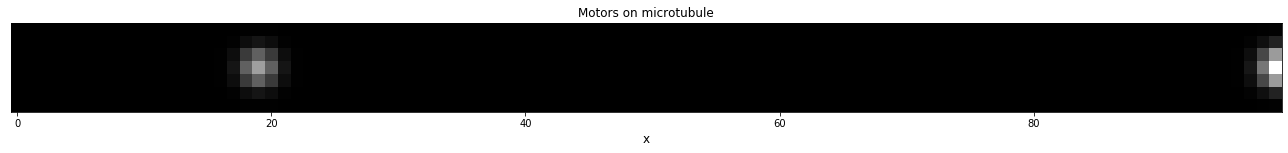

In [23]:
#check reformatting is working by plotting a random frame - if you don't see anything in the first frame, there may be no motors in this frame, so run it a couple times
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(18, 2))

ax.imshow(padded_stack[np.random.randint(0,nstep),], cmap='gray', interpolation='nearest')
ax.set_title("Motors on microtubule", fontsize=12)
ax.axes.get_yaxis().set_visible(False)
ax.set_xlabel("x", fontsize=12)

plt.tight_layout()
plt.show()

In [24]:
#save a movie of the simulation
if zsave == True:
    fps = 100
    img_array = []

    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_movie_{}.avi'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)

    for i in range(mt.shape[0]):
        img = padded_stack[i,].astype(np.uint8)
        height, width = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(results_dir + file_name,cv2.VideoWriter_fourcc(*'M','J','P','G'), fps, size, False) #'DIVX'

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

### TO DO:
* Fix affinity decay with time??
* Run simulation with time steps as above, but sample at 100ms frame rate
* Check affinity update
* compare to Bela's result - density of motors for non-cooperative case
